<a href="https://colab.research.google.com/github/AndresMontesDeOca/TimeSeries/blob/main/Machete_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machete Series Temporales

## Imortamos Librerias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

## Cargamos el Dataset

In [101]:
url='https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/Index2018.csv'
raw_csv_data = pd.read_csv(url)
data=raw_csv_data.copy()

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6277 entries, 0 to 6276
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6277 non-null   object 
 1   spx     6277 non-null   float64
 2   dax     6277 non-null   float64
 3   ftse    6277 non-null   float64
 4   nikkei  6277 non-null   float64
dtypes: float64(4), object(1)
memory usage: 245.3+ KB
None


,date,spx,dax,ftse,nikkei
0,7/1/1994,469.90,2224.95,3445.98,18124.01
1,10/1/1994,475.27,2225.00,3440.58,18443.44
2,11/1/1994,474.13,2228.10,3413.77,18485.25
3,12/1/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


## Pre-Procesamiento

In [102]:
# Convertiamos a Date, formato DD/MM/YYYY
data['date'] = pd.to_datetime(data['date'], dayfirst=True).copy()

# Seteamos 'date' como Index
data.set_index('date', inplace=True)

# Nos quedamos solo con 'spx', para simplificar
data.drop(columns=['dax', 'ftse', 'nikkei'], inplace=True)

# Renombramos spx a SPX
data.rename(columns={'spx':'SPX'}, inplace=True)

# Adaptamos distintas frecuencias temporales
# display(data.asfreq('b').head()) # Business Day
# data.asfreq('d').head() # Completa dias faltantes con null
# data.asfreq('m').head() # Mes

data.head()

,SPX
date,
1994-01-07,469.90
1994-01-10,475.27
1994-01-11,474.13
1994-01-12,474.17
1994-01-13,472.47


## Visualizacion

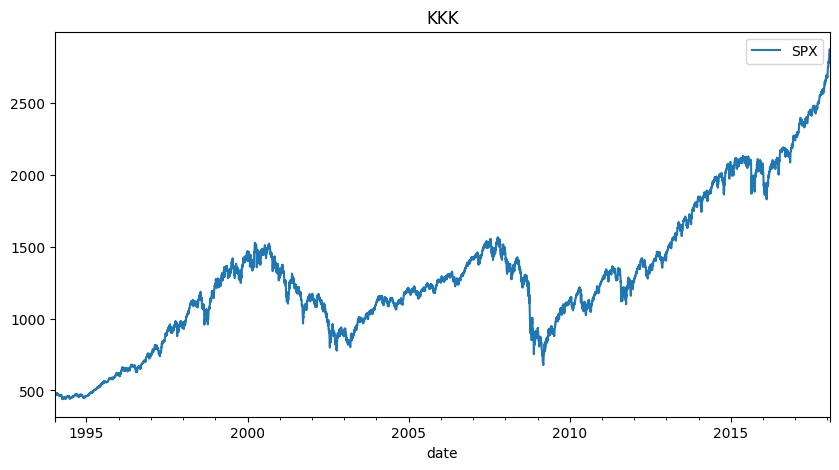

In [103]:
# Visualizamos
data.plot(figsize=(10, 5), title='KKK')
# plt.plot(data)

plt.show()

## Determinamos Rolling Statistics (Moving Averages?)

In [104]:
# Rolling Mean
rolmean = data.rolling(window=12).mean().rename(columns={'SPX':'RM'})

# Rolling Standard Dev
rolstd = data.rolling(window=12).std().rename(columns={'SPX':'RSD'})

# Concateno en el Dataset Original
data = pd.concat([data, rolmean, rolstd], axis=1)

data.tail()

,SPX,RM,RSD
date,,,
2018-01-23,2839.130362,2787.223367,30.970672
2018-01-24,2837.544008,2794.709515,31.405526
2018-01-25,2839.253031,2802.040163,30.604478
2018-01-26,2872.867839,2812.427025,31.807479
2018-01-29,2853.528411,2819.591215,30.434837


## Ploteamos Rolling Statistics

<Axes: xlabel='date'>

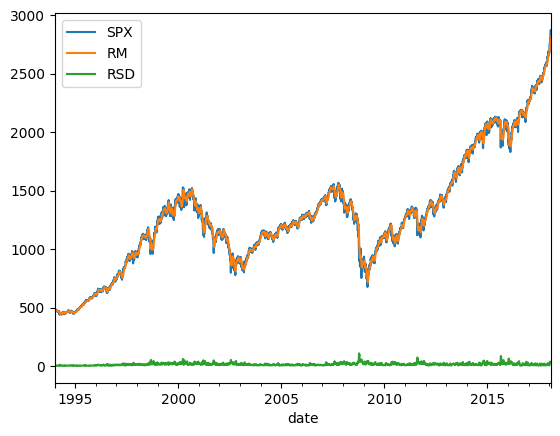

In [106]:
# Confirmar si esta bien
data.plot()

# Para que sean Estacionarias, RM y RSD deberian ser constantes. RM no lo es

## Test Analitico Augmented Dickey–Fuller (ADCF)

In [115]:
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import acf, pacf


# Realizo el test y me traigo solo el p-value
adfuller(data['SPX'])[1]

# No puedo rechazar H0 de No-Estacionariedad

0.9953796476080692

## Test Grafico Funcion de Autocorrelacion (ACF)

Trend = Decrece Linealmente\
Seasonality = Aparecen Valles


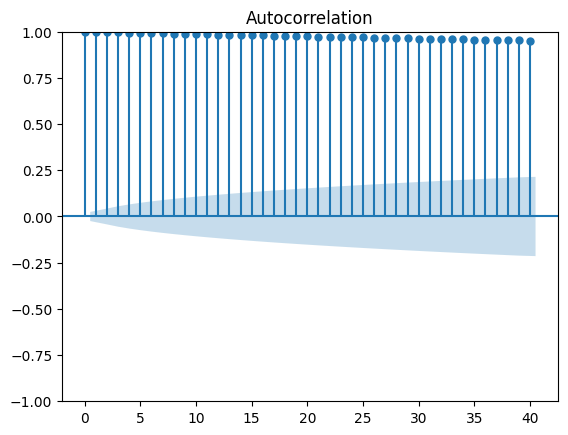

In [133]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data['SPX'], lags=40)
plt.show()

## Descomposicion de la Serie (no entiendo para que sirve)

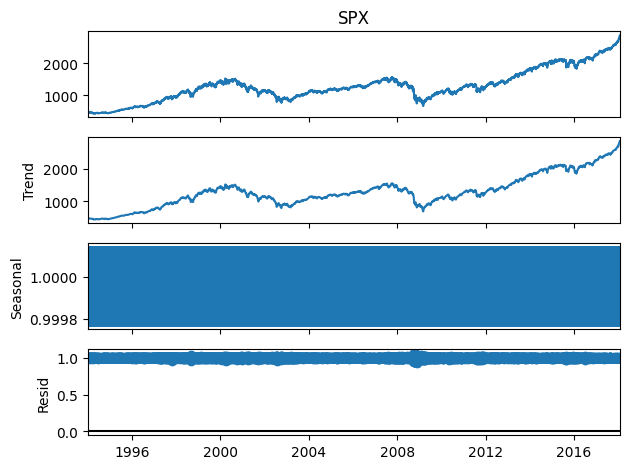

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose

data_dec = seasonal_decompose(data['SPX'], model='multiplicative', period=None) # aditive
data_dec.plot()
plt.show()

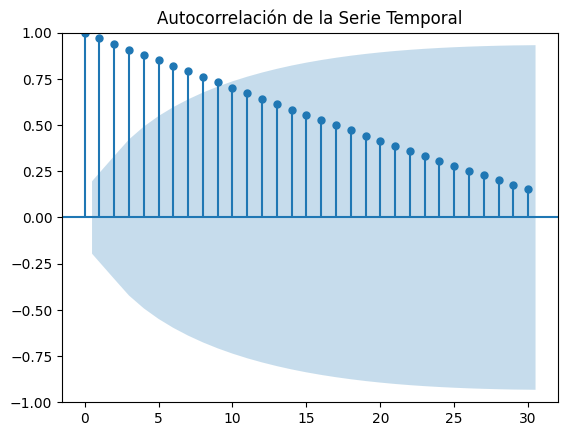

In [128]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Crear una serie temporal de ejemplo
np.random.seed(0)
t = np.arange(0, 100)
y = 3 * t + 2 * np.sin(2 * np.pi * t / 12) + np.random.normal(0, 2, 100)
df = pd.DataFrame({'y': y})

# Calcular y graficar la autocorrelación
acf = sm.tsa.graphics.plot_acf(df['y'], lags=30)
plt.title('Autocorrelación de la Serie Temporal')
plt.show()
